<a href="https://colab.research.google.com/github/ChabiMax/author_network/blob/main/Code/Question%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Réseau Wikipédia des auteurs francophones</font></strong></center></h1>
<h5><center><font color="green">Science des réseaux sociaux et économiques <h3><center>


<center>
Maxime Chabriel, Yasmine Houri, Mathis Sansu  

ENSAE 2022
</center>

<h2><center><strong><font color="chillipepper">Analyses</font></strong></center></h2>

# Packages

In [109]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import pickle as pkl
!pip install python-louvain


# Données

In [179]:
# Lien du repository GitHub pour récupérer les données
git_url = "https://raw.githubusercontent.com/ChabiMax/author_network/main/"
data = pd.read_pickle(git_url+'/Data/raw_data.pkl')

In [181]:
# Passage du dictionnaire sous forme de dataframe
df = pd.DataFrame(data).T
df.head()

,name,link,date_mort,date_naissance,taille_html_article,network_interauteur,poids_liens_interauteur,genres_mentionnes,type,contemporain,poids_contempo_diff_naissance,poids_contempo_annees_communes,auteurs_du_genre,debut_genre,fin_genre
0,Turold,https://fr.wikipedia.org/wiki/Turold,NaN,NaN,73673,[],[],[],auteur,[],[],[],NaN,NaN,NaN
1,Philippe de Thaon,https://fr.wikipedia.org/wiki/Philippe_de_Thaon,NaN,NaN,68910,[],[],[],auteur,[],[],[],NaN,NaN,NaN
2,Benoît de Sainte-Maure,https://fr.wikipedia.org/wiki/Beno%C3%AEt_de_S...,NaN,NaN,83269,[4],[1],[1627],auteur,[],[],[],NaN,NaN,NaN
3,Jean Bodel,https://fr.wikipedia.org/wiki/Jean_Bodel,1165,NaN,73274,"[10, 22]","[1, 1]","[1663, 1691, 1604]",auteur,[],[],[],NaN,NaN,NaN
4,Wace,https://fr.wikipedia.org/wiki/Wace,1174,1100,99714,[6],[2],"[1591, 1662]",auteur,"[5, 6, 7, 9, 10, 11]","[10, 30, 50, 60, 60, 60]","[52, 44, 24, 14, 14, 14]",NaN,NaN,NaN


# Réseau interauteurs : hyperliens auteurs sur les pages auteurs

## Table des liens

In [182]:
id = 0 # Initialisation
id_link = id 
link_table = dict()

for source in df.index :
  if df.iloc[id]['type'] == "auteur":
    for i in range(len(df.iloc[id]['network_interauteur'])):
      target = df.iloc[id]['network_interauteur'][i]
      link_table[id_link] = {'source' : source, 'target' : target}
      weight = df.iloc[id]['poids_liens_interauteur'][i]
      link_table[id_link]['weight'] = weight
      if target in df.iloc[id]['contemporain'] :
        index_contemp = df.iloc[id]['contemporain'].index(target)
        contemporain = 1
        diff_naissance = df.iloc[id]['poids_contempo_diff_naissance'][index_contemp]
        annees_communes = df.iloc[id]['poids_contempo_annees_communes'][index_contemp]
      else:
        contemporain = 0
        diff_naissance = 0
        annees_communes = 0
      link_table[id_link]['contemporain'] = contemporain
      link_table[id_link]['diff_naissance'] = diff_naissance
      link_table[id_link]['annees_communes'] = annees_communes
      id_link +=1
    id += 1

In [183]:
edge_links = pd.DataFrame(link_table).T
edge_links.head()

,source,target,weight,contemporain,diff_naissance,annees_communes
0,2,4,1,0,0,0
1,3,10,1,0,0,0
2,3,22,1,0,0,0
3,4,6,2,1,30,44
4,6,4,1,1,30,44


## Réseau complet

In [184]:
# Graph orienté
GraphAuthorLink = nx.from_pandas_edgelist(edge_links, 'source', 'target', edge_attr = True, create_using=nx.DiGraph())

In [185]:
print(nx.info(GraphAuthorLink))

DiGraph with 1250 nodes and 13021 edges


In [186]:
# match nodes of graph with attributes of nodes
df_node = df[df["type"] == "auteur"]
df_node['Node'] = df_node.index
NodeData = df_node.set_index('Node').to_dict('index').items()
GraphAuthorLink.add_nodes_from(NodeData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [187]:
print(nx.info(GraphAuthorLink))

DiGraph with 1584 nodes and 13021 edges


## Caractéristiques

In [188]:
# Removing isolates
GraphAuthorLink_withoutiso = GraphAuthorLink
GraphAuthorLink_withoutiso.remove_nodes_from(list(nx.isolates(GraphAuthorLink_withoutiso)))

In [189]:
# Nombre de noeuds
N_nodes = GraphAuthorLink_withoutiso.number_of_nodes()
print(N_nodes)

1250


In [190]:
# Liens sortants
print(GraphAuthorLink_withoutiso.out_degree())
# Liens entrants
print(GraphAuthorLink_withoutiso.in_degree())
# Liens totaux
print(GraphAuthorLink_withoutiso.degree())

[(2, 1), (4, 1), (3, 2), (10, 0), (22, 0), (6, 2), (732, 65), (7, 1), (11, 3), (18, 3), (21, 3), (14, 5), (13, 0), (1, 0), (102, 0), (15, 2), (17, 1), (24, 3), (19, 3), (729, 46), (733, 58), (779, 33), (39, 2), (25, 1), (26, 1), (29, 1), (35, 3), (30, 1), (198, 18), (31, 3), (37, 3), (20, 0), (34, 4), (443, 18), (375, 24), (913, 40), (38, 1), (51, 2), (40, 8), (73, 12), (523, 13), (665, 26), (326, 25), (41, 4), (98, 1), (50, 1), (42, 1), (44, 2), (60, 3), (45, 1), (46, 4), (56, 22), (1255, 3), (1273, 22), (47, 2), (48, 1), (59, 3), (58, 1), (52, 1), (53, 1), (565, 17), (197, 3), (70, 31), (213, 11), (376, 69), (402, 21), (431, 7), (515, 43), (422, 32), (480, 30), (391, 21), (502, 27), (680, 15), (731, 23), (672, 26), (978, 43), (67, 8), (64, 2), (248, 51), (366, 14), (62, 1), (66, 2), (71, 6), (93, 18), (92, 5), (68, 2), (69, 1), (79, 4), (65, 0), (1004, 15), (601, 16), (104, 2), (199, 42), (203, 5), (171, 3), (329, 36), (339, 32), (387, 28), (424, 20), (355, 29), (570, 27), (572, 8), 

In [191]:
# Densité
print(nx.density(GraphAuthorLink_withoutiso))
# Réciprocité globale
print(nx.reciprocity(GraphAuthorLink_withoutiso))
# Réciprocité locale
print(nx.reciprocity(GraphAuthorLink_withoutiso, nodes = GraphAuthorLink_withoutiso.nodes))
# Transitivité
print(nx.transitivity(GraphAuthorLink_withoutiso)) # Coeff de cluster global
print(nx.clustering(GraphAuthorLink_withoutiso)) # Coeff de cluster local
print(nx.average_clustering(GraphAuthorLink_withoutiso)) # Coeff de cluster local moyen

0.008340112089671737
0.5131710314107979
{2: 0.0, 4: 0.5, 3: 0.0, 10: 0.0, 22: 0.0, 6: 0.2222222222222222, 732: 0.6413043478260869, 7: 0.0, 11: 0.6666666666666666, 18: 0.8, 21: 0.8, 14: 0.0, 13: 0.0, 1: 0.0, 102: 0.0, 15: 0.0, 17: 0.6666666666666666, 24: 0.4444444444444444, 19: 0.0, 729: 0.460431654676259, 733: 0.46153846153846156, 779: 0.7792207792207793, 39: 0.8, 25: 0.0, 26: 0.0, 29: 1.0, 35: 0.6666666666666666, 30: 0.0, 198: 0.3, 31: 0.6666666666666666, 37: 0.2857142857142857, 20: 0.0, 34: 0.4, 443: 0.5660377358490566, 375: 0.44155844155844154, 913: 0.8089887640449438, 38: 0.0, 51: 0.5, 40: 0.2, 73: 0.3333333333333333, 523: 0.3333333333333333, 665: 0.10526315789473684, 326: 0.6774193548387096, 41: 0.0, 98: 0.0, 50: 0.0, 42: 0.0, 44: 0.0, 60: 0.0, 45: 0.0, 46: 0.25, 56: 0.21739130434782608, 1255: 0.0, 1273: 0.35, 47: 0.0, 48: 0.0, 59: 0.4, 58: 1.0, 52: 0.0, 53: 0.0, 565: 0.26666666666666666, 197: 0.3076923076923077, 70: 0.21818181818181817, 213: 0.2962962962962963, 376: 0.50925925925

In [192]:
# Cliques
print(list(nx.find_cliques(GraphAuthorLink_withoutiso.to_undirected())))
# Connectivité
print(nx.is_connected(GraphAuthorLink_withoutiso.to_undirected()))
# Connectivité faible
print(nx.is_weakly_connected(GraphAuthorLink_withoutiso))

[[0, 1090], [1, 14], [2, 4, 14], [3, 56], [3, 10], [3, 22], [4, 6], [6, 929], [6, 11, 18, 21], [6, 1524], [6, 1525], [6, 732], [7, 11], [7, 15], [13, 14], [14, 102], [15, 25], [15, 22], [17, 24, 96], [19, 729, 779, 733], [20, 56], [20, 31], [22, 24], [22, 891], [24, 50], [24, 67], [24, 39, 40], [26, 732], [29, 35], [30, 198], [31, 35, 37], [31, 1524], [34, 913], [34, 35], [34, 443], [34, 375], [35, 42], [35, 44], [37, 40], [37, 198], [37, 46, 56], [38, 51], [39, 41], [40, 326, 523], [40, 73], [40, 792, 732], [40, 665], [41, 72, 73], [41, 50], [41, 67, 73], [41, 67, 98], [41, 47], [44, 60], [45, 198], [46, 56, 817], [46, 56, 1445], [46, 1273], [46, 900], [46, 1255], [47, 56], [48, 59], [51, 73], [51, 58], [52, 60], [53, 198], [59, 56], [59, 67, 64], [60, 56], [60, 366, 248], [61, 99], [62, 73], [63, 72], [64, 73, 67], [65, 72, 70], [65, 99], [65, 95], [66, 73, 71], [67, 73, 93], [67, 73, 70], [67, 92, 93], [69, 70], [71, 147], [71, 93, 104, 73], [71, 93, 104, 92], [71, 93, 84, 73], [71,

In [193]:
# Centralité de degré
print(nx.degree_centrality(GraphAuthorLink_withoutiso))
# Centralité de degré entrant
print(nx.in_degree_centrality(GraphAuthorLink_withoutiso))
# Centralité de degré sortant
print(nx.out_degree_centrality(GraphAuthorLink_withoutiso))
# In-edge centralité de vecteur propre
print(nx.eigenvector_centrality(GraphAuthorLink_withoutiso))
# Out-edge centralité de vecteur propre
print(nx.eigenvector_centrality(GraphAuthorLink_withoutiso.reverse()))
# Centralité de distance (inward)
print(nx.closeness_centrality(GraphAuthorLink_withoutiso))
# Centralité de distance (outward)
print(nx.closeness_centrality(GraphAuthorLink_withoutiso.reverse()))
# Centralité betweenness
print(nx.betweenness_centrality(GraphAuthorLink_withoutiso))

{2: 0.0016012810248198558, 4: 0.0032025620496397116, 3: 0.0024019215372297837, 10: 0.0008006405124099279, 22: 0.0032025620496397116, 6: 0.007205764611689351, 732: 0.14731785428342672, 7: 0.0016012810248198558, 11: 0.004803843074459567, 18: 0.0040032025620496394, 21: 0.0040032025620496394, 14: 0.0040032025620496394, 13: 0.0008006405124099279, 1: 0.0008006405124099279, 102: 0.0008006405124099279, 15: 0.0024019215372297837, 17: 0.0024019215372297837, 24: 0.007205764611689351, 19: 0.0024019215372297837, 729: 0.11128903122497998, 733: 0.07285828662930344, 779: 0.06164931945556445, 39: 0.0040032025620496394, 25: 0.0008006405124099279, 26: 0.0008006405124099279, 29: 0.0016012810248198558, 35: 0.007205764611689351, 30: 0.0008006405124099279, 198: 0.04803843074459567, 31: 0.004803843074459567, 37: 0.005604483586869495, 20: 0.0016012810248198558, 34: 0.0040032025620496394, 443: 0.04243394715772618, 375: 0.06164931945556445, 913: 0.07125700560448359, 38: 0.0008006405124099279, 51: 0.0032025620496

# Question 2 - Baseline


On visualise notre variable dépendente : le nombre de nouveaux genres littéraires apparaissant à une date donnée. 

(array([ 3.,  1.,  0.,  6.,  0.,  5.,  0.,  0.,  1.,  4.,  3.,  1.,  0.,
         2.,  4.,  1.,  0.,  8.,  9.,  5.,  2.,  3., 15.,  6.,  5.,  0.,
         1.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  1.,  5.,  7.,  4.,  2.,
        12.]),
 array([1100.0, 1121.825, 1143.65, 1165.475, 1187.3, 1209.125, 1230.95,
        1252.775, 1274.6, 1296.425, 1318.25, 1340.075, 1361.9, 1383.725,
        1405.55, 1427.375, 1449.2, 1471.025, 1492.85, 1514.675, 1536.5,
        1558.325, 1580.15, 1601.975, 1623.8, 1645.625, 1667.4499999999998,
        1689.275, 1711.1, 1732.925, 1754.75, 1776.5749999999998, 1798.4,
        1820.225, 1842.05, 1863.875, 1885.6999999999998, 1907.525, 1929.35,
        1951.175, 1973.0], dtype=object),
 <a list of 40 Patch objects>)

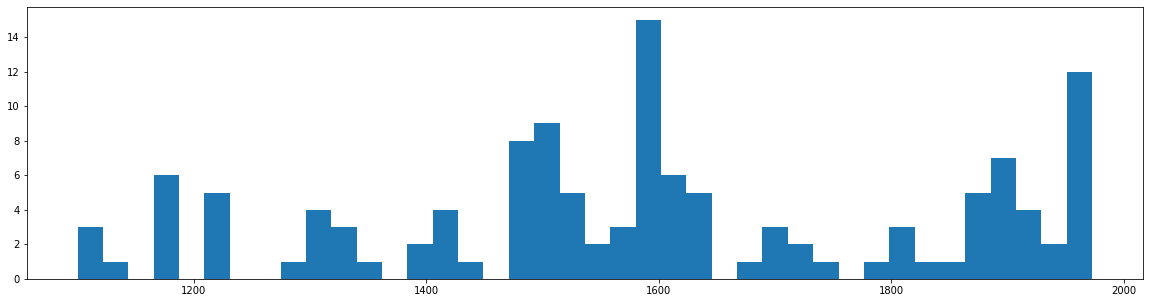

In [194]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

df_genre = df[df['type'] == 'genre']
df_genre = df_genre[df_genre['debut_genre'] != 9999]

plt.hist(df_genre['debut_genre'], bins = 40)

On produit des métriques pour chaque sous-graphe-année pour tester visuellement si il existe une relation potentielle entre la structure du réseau et l'apparition d'un nouveau graph.

In [195]:
from community import community_louvain
from tqdm import tqdm_notebook
import numpy as np

# Year subsets and building metrics
df_auteurs = df[df['type'] == 'auteur']
measure_list = {}
for année in tqdm_notebook(reversed(range(1000, 2025, 5))) :
  selected_nodes = [node for node, value in GraphAuthorLink.nodes(data=True) if (value['date_mort'] >= année) & (value['date_naissance'] <= année)] 
  subgraph = GraphAuthorLink.subgraph(selected_nodes)
  # if len(selected_nodes) > 10 :
  if len(selected_nodes) > 1 :
    try :
      subgraph_undirected = subgraph.to_undirected()
      subgraph_undirected_connected_components = sorted(nx.connected_components(subgraph_undirected), key=len, reverse=True)
      subgraph_undirected_giant = subgraph_undirected.subgraph(subgraph_undirected_connected_components[0])
      community = community_louvain.best_partition(subgraph_undirected, randomize = False)
      community_giant = community_louvain.best_partition(subgraph_undirected_giant, randomize = False)
      measure_list[année] = {'graph_size' : subgraph.number_of_nodes(),
                             'graph_giant_size' : subgraph_undirected_giant.number_of_nodes(),
                             'density_undirected' : nx.density(subgraph_undirected),
                             'density_directed' : nx.density(subgraph), 
                             'density_giant' : nx.density(subgraph_undirected_giant),
                             'average_clustering' : nx.average_clustering(subgraph_undirected_giant),
                             'transitivity' : nx.transitivity(subgraph),
                             'community' : max(list(community)),
                             'community_giant' : max(list(community_giant.values())),
                             'community_giant_variance' : np.var(list(community_giant.values())),
                             'modularity' : community_louvain.modularity(community_giant, subgraph_undirected_giant)}
    except : 
      pass

annee_data = pd.DataFrame(measure_list).T
annee_data['annee'] = annee_data.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

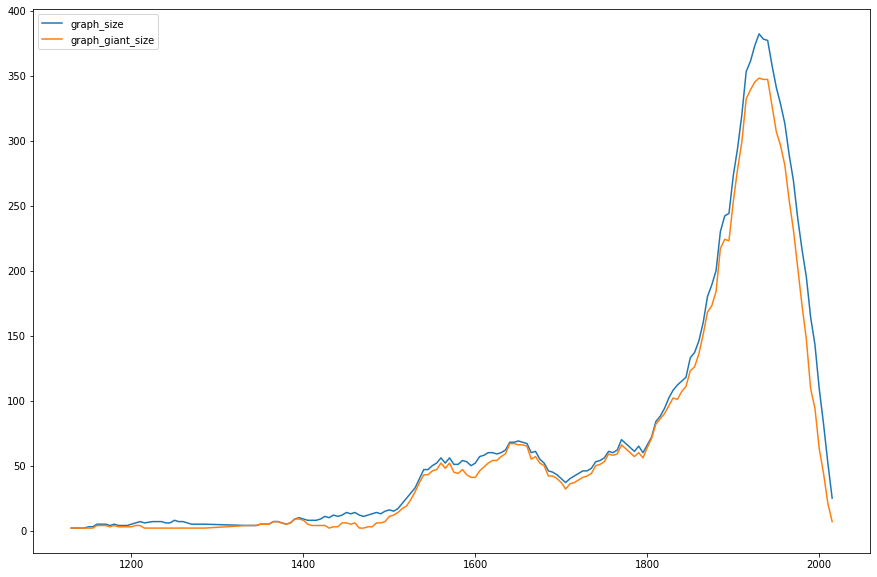

In [196]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['graph_size'], label = 'graph_size')
plt.plot(annee_data['annee'], annee_data['graph_giant_size'], label = 'graph_giant_size')
plt.legend()
plt.show()

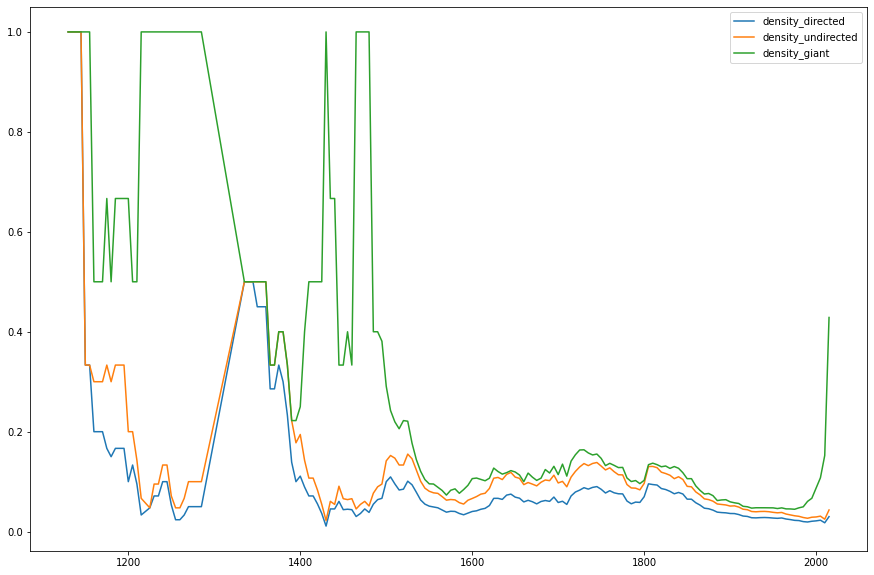

In [197]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['density_directed'], label = 'density_directed')
plt.plot(annee_data['annee'], annee_data['density_undirected'], label = 'density_undirected')
plt.plot(annee_data['annee'], annee_data['density_giant'], label = 'density_giant')
plt.legend()
plt.show()

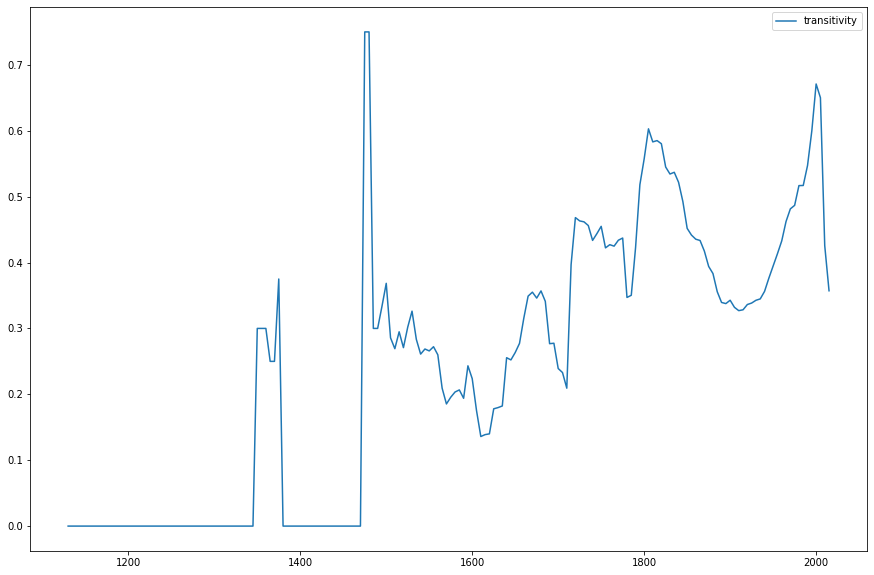

In [198]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['transitivity'], label = 'transitivity')
plt.legend()
plt.show()

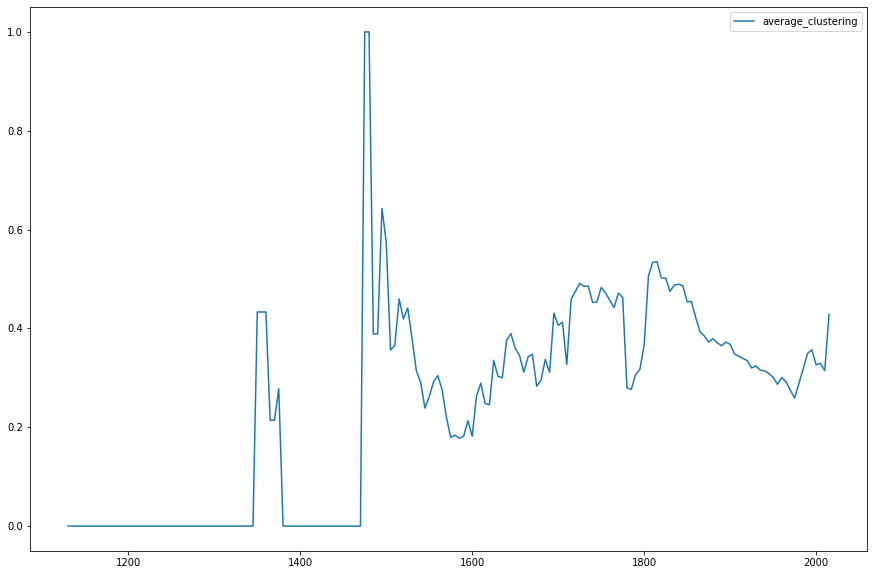

In [199]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
plt.legend()
plt.show()

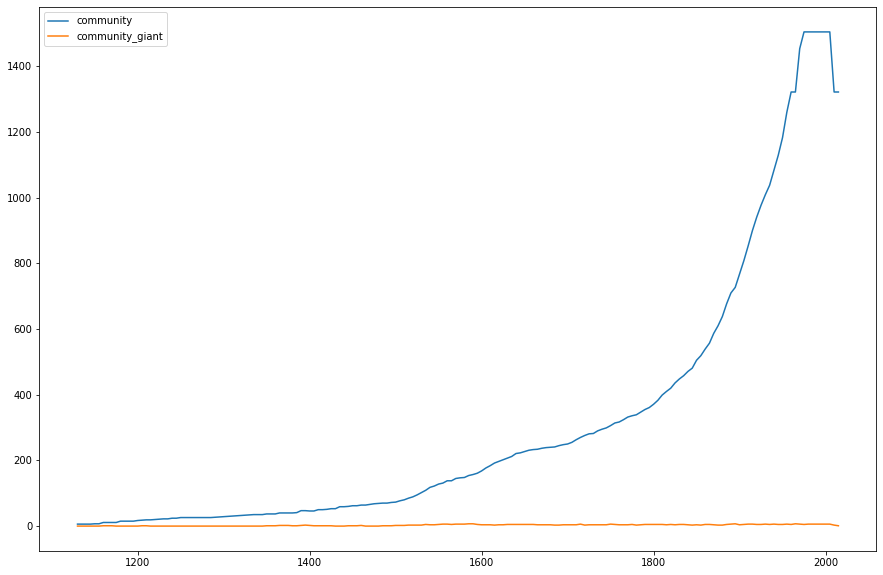

In [200]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['community'], label = 'community')
plt.plot(annee_data['annee'], annee_data['community_giant'], label = 'community_giant')
plt.legend()
plt.show()

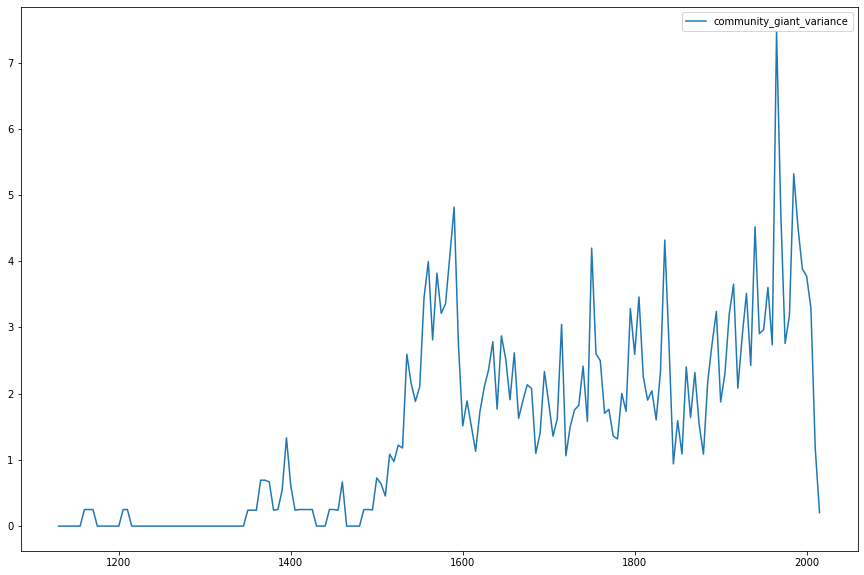

In [201]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['community_giant_variance'], label = 'community_giant_variance')
plt.legend()
plt.show()

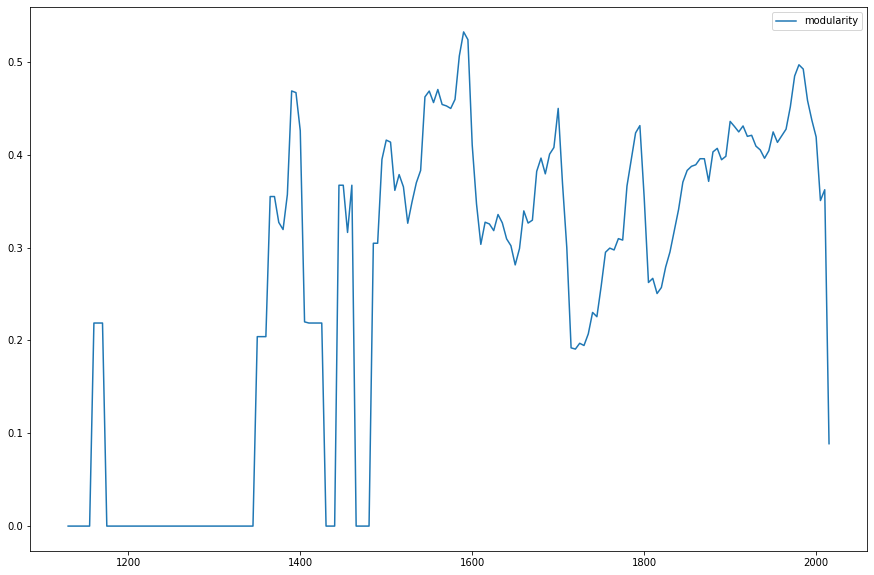

In [202]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['modularity'], label = 'modularity')
plt.legend()
plt.show()

Comparaison

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Year')

Text(0, 0.5, 'average_clustering')

Text(0, 0.5, 'density nb new graph')

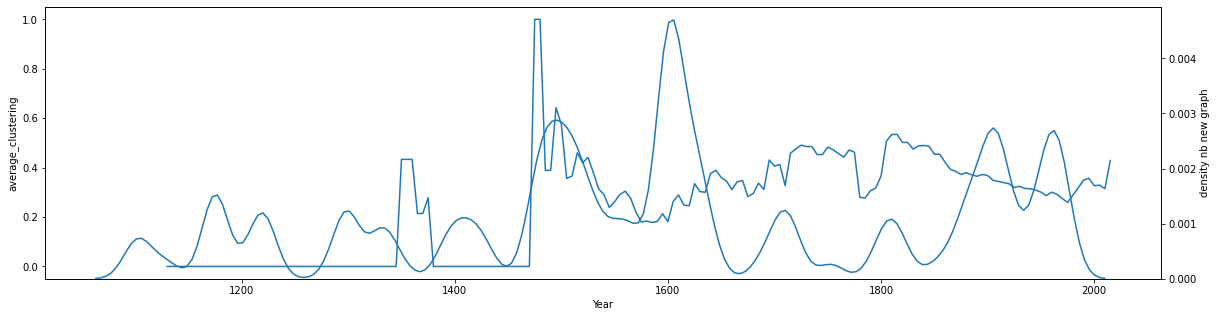

In [203]:
import seaborn as sns
import numpy as np

plt.rcParams['figure.figsize'] = [20, 5]

df_genre = df[df['type'] == 'genre']
df_genre = df_genre[df_genre['debut_genre'] != 9999]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
sns.kdeplot(df_genre['debut_genre'], bw=0.05, ax = ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('average_clustering')
ax2.set_ylabel('density nb new graph')

plt.show()



# Question 2 - Subset taille de page

Visualisation de la répartition des tailles d'articles (mise au log).

(array([  1.,   0.,   0.,   0.,   0.,   0.,   4.,  25.,  55., 102., 115.,
        138., 104., 140., 114., 115., 101.,  82.,  75.,  59.,  64.,  54.,
         47.,  25.,  35.,  24.,  17.,  24.,  17.,   7.,   8.,   1.,   7.,
          2.,   5.,  10.,   4.,   1.,   0.,   2.]),
 array([ 9.99729661, 10.09837902, 10.19946143, 10.30054384, 10.40162625,
        10.50270866, 10.60379107, 10.70487348, 10.80595589, 10.9070383 ,
        11.00812071, 11.10920312, 11.21028553, 11.31136794, 11.41245035,
        11.51353276, 11.61461518, 11.71569759, 11.81678   , 11.91786241,
        12.01894482, 12.12002723, 12.22110964, 12.32219205, 12.42327446,
        12.52435687, 12.62543928, 12.72652169, 12.8276041 , 12.92868651,
        13.02976892, 13.13085133, 13.23193374, 13.33301615, 13.43409857,
        13.53518098, 13.63626339, 13.7373458 , 13.83842821, 13.93951062,
        14.04059303]),
 <a list of 40 Patch objects>)

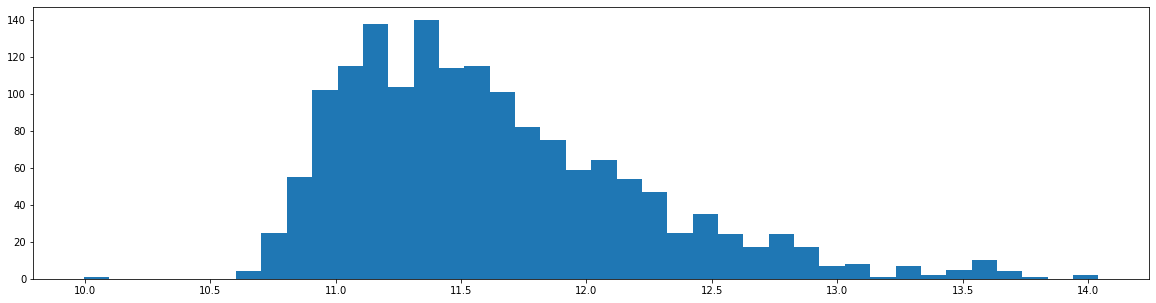

In [204]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.hist(np.log(pd.to_numeric(df_auteurs['taille_html_article'])), bins = 40)

On visualise la relation entre la taille de l'article d'un auteur et son nombre de connexions. 

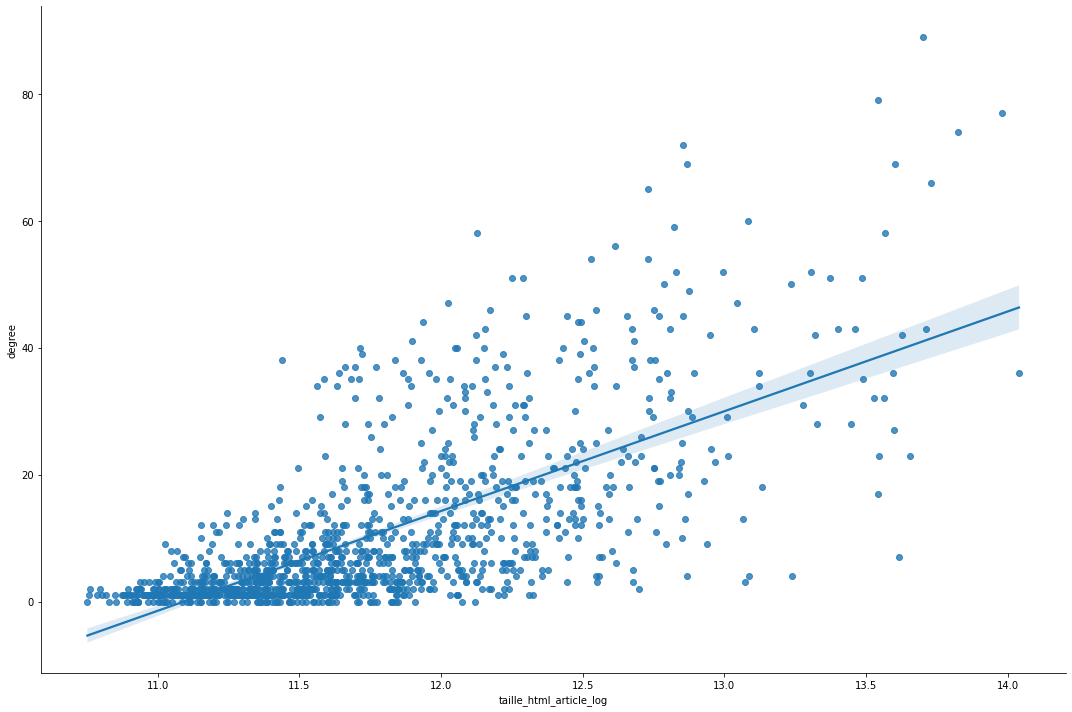

In [205]:
plt.rcParams['figure.figsize'] = [20, 5]

# nx.get_node_attributes(GraphAuthorLink, 'taille_html_article')
tailles = nx.get_node_attributes(GraphAuthorLink, 'taille_html_article')
tailles = pd.DataFrame(tailles.items())
degrees = dict()
for (node, val) in GraphAuthorLink.out_degree() :
  degrees[node] = val
degrees = pd.DataFrame(degrees.items())
degree_tailles_df = pd.merge(degrees, tailles, on=0, how='outer')
degree_tailles_df.columns = ['Id', 'degree', 'taille_html_article']
degree_tailles_df['taille_html_article_log'] = np.log(degree_tailles_df['taille_html_article'])
sns.lmplot(y = "degree", x = "taille_html_article_log", data = degree_tailles_df, height = 10, aspect = 15/10)

Un poids de la relation de l'auteur $i$ à l'auteur $j$ par la présence d'un hyperlien dans vers $j$ dans la page de $i$ était déjà fixé en fonction du nombre d'hyperlien vers $j$ que l'on trouvait dans la page de $i$ (notons ces poids $w_{i,j}$). Pour déterminer l'influence de la taille d'un article $i$ ($X_{i}$) sur son nombre de connexion ($Y_{i}$), on décide d'effectuer une régression linéaire :

(1) $Y_{i} = \beta log(X_{i}) + ϵ_{i}$

Notons bien que l'intercept est fixé à 0 (en effet, la relation $f$ entre la taille d'un article x et le nombre d'hypeliens qu'il inclut en son sein $f(x)$ ne fait aucun sens si on n'a pas $f(x) = 0$). Les résidus $ϵ$ de (1) (qu'on maximise à au minimum 0.1 pour éviter de faire disparaître certains liens) sont alors le nombre "réel" de relations (c'est à dire le nombre de relations retranché de l'effet artificiel de la taille de l'article) que l'auteur possède avec d'autres auteurs par les hyperliens présents sur sa page. 

Les poids $w_{i,j}$ sont donc actualisés en des $w'_{i,j}$ de façon à ce que leur somme fasse $ϵ_{i}$.

$w'_{i,j} = w_{i,j}*\frac{max(ϵ_{i}, \: 0.1)}{\sum_{j}w_{i,j}}$


In [206]:
from tqdm import tqdm_notebook
import statsmodels.formula.api as smf
model = smf.ols("degree ~ taille_html_article_log -1", data = degree_tailles_df)
model = model.fit()
coeff_reg = model.params['taille_html_article_log']
# intercept_reg = model.params['Intercept']

df['poids_liens_interauteur2'] = None
min_true_degrees = 0
for auteur in tqdm_notebook(df['name'][df['type'] == 'auteur']) :
  idx = int(df[df['name'] == auteur].index[0])
  poids = df[df['name'] == auteur]['poids_liens_interauteur']
  poids = list(poids)[0]
  if poids != [] :
    true_degree = list(len(df[df['name'] == auteur]['poids_liens_interauteur']) - coeff_reg*np.log(pd.to_numeric(df[df['name'] == auteur]['taille_html_article'])))[0]
    min_true_degrees = min(min_true_degrees, true_degree)

for auteur in tqdm_notebook(df['name'][df['type'] == 'auteur']) :
  idx = int(df[df['name'] == auteur].index[0])
  poids = df[df['name'] == auteur]['poids_liens_interauteur']
  poids = list(poids)[0]
  if poids != [] :
    true_degree = list(len(df[df['name'] == auteur]['poids_liens_interauteur']) - coeff_reg*np.log(pd.to_numeric(df[df['name'] == auteur]['taille_html_article'])))[0]
    #normalisation_coeff = (true_degree - min_true_degrees + 0.1) / sum(poids)
    normalisation_coeff = max(true_degree, 0.1) / sum(poids)
    poids = [poid * normalisation_coeff for poid in poids]
  else :
    poids = []
  df.at[idx,'poids_liens_interauteur2'] = poids


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/1584 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1584 [00:00<?, ?it/s]

In [207]:
for node in GraphAuthorLink.nodes() :
  network = df['network_interauteur'][node]
  for i in range(0, len(network)) :
    indiv = network[i]
    GraphAuthorLink[node][indiv]['weight2'] = df['poids_liens_interauteur2'][node][i]

Les genres sont problématiques car leur dénombrement est confronté à de nombreux biais. Notamment, certains genres sont imbriqués les uns dans les autres, ce qui les démultiplie artificiellement. Cependant on ne peut pas non plus les subsumer les uns dans les autres car on est confronté à la création de nouvelles interférences : quels genres subsumer, à quel niveau ? Tous le genre ne sont pas exactement imbriqués les uns dans les autres, et les recoupement se font dans un espace continu, comment prendre cette dimension en compte ? 

Notre projet avait ainsi défini le genre littéraire : un vision de l'écriture ou une manière d'écrire qui peut se définir par une communauté d'auteur partageant cette vision ou empruntant des éléments du genre en question dans leur propre travail. Si un genre peut se définir par une communauté d'auteur, on peut alors dire que la proximité entre deux genres dépend se mesurer par le nombre d'auteurs communs à leurs communautés respectives. Pour un genre $i$, on peut définir un poids $w_{i}$ tel que : 

$w_{i} = \prod_{j} \frac{\#(auteur \: dans \: i \: et \: j)}{\#(auteurs \: dans \: i) \:+\: \#(auteurs \: dans \: j)}$

In [208]:
df['poids_genre'] = None
df.loc[df['type'] == 'genre', 'poids_genre'] = 1

for genre in tqdm_notebook(np.unique(df[df['type'] == 'genre']['name'])) :
  for genre_bis in np.unique(df[df['type'] == 'genre']['name']) :
    if genre != genre_bis :
      auteurs_du_genre = df.loc[df['name'] == genre, 'auteurs_du_genre']
      auteurs_du_genre_bis = df.loc[df['name'] == genre_bis, 'auteurs_du_genre']
      liste = list(auteurs_du_genre)[0]
      liste_bis = list(auteurs_du_genre_bis)[0]
      if (len(liste) != 0) & (len(liste_bis) != 0) :
        coeff = len(np.unique(liste + liste_bis)) / (len(liste) + len(liste_bis))
        df.loc[df['name'] == genre, 'poids_genre'] = df.loc[df['name'] == genre, 'poids_genre']*(coeff/2)
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/190 [00:00<?, ?it/s]

Aussi, l'année dite de début d'un genre est très sensible aux légères variabilités (théorie des valeurs extrêmes) : un genre mentionné par simple hasard sur la page d'un auteur du sièce précédent fait décaler toute la valeur d'un siècle. Pour désigner l'année de début, on peut se résoudre à faire un moyenne des 2 premières années d'apparition, en excluant la première. 

In [209]:
df['debut_genre_moyenne3'] = None
for genre in df[df['type'] == 'genre'].index :
  subset = df[df['genres_mentionnes'].apply(str).str.contains(str(genre)).tolist()]
  annees = np.unique(subset.date_naissance)
  annees = [x for x in annees if str(x) != 'nan']
  annees = np.sort(annees)[1:3]
  if len(annees) >= 2 :
    df.loc[genre, 'debut_genre_moyenne3'] = np.average(annees)

On visualise la différence entre la densité avec poids et sans poids.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


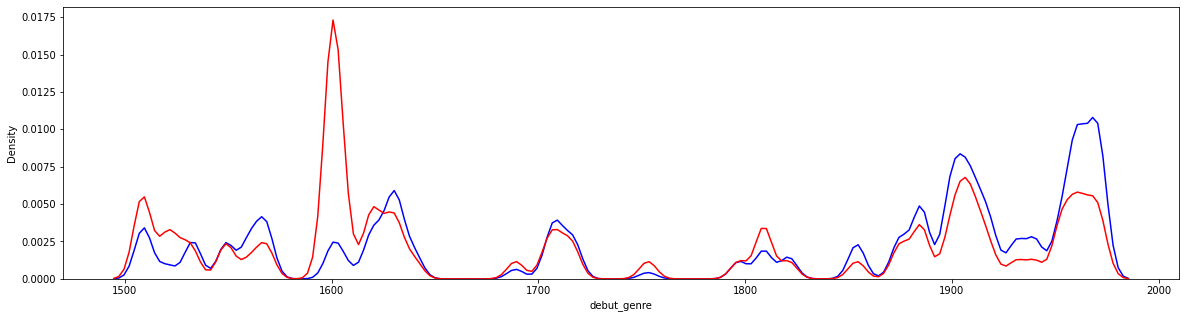

In [210]:
df_genre = df[df['type'] == 'genre']
date_debut = 1500 
date_fin = 2050
BOOL_genre = (df_genre['debut_genre'] > date_debut) & (df_genre['debut_genre'] < date_fin)

sns.kdeplot('debut_genre', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', color = 'blue', data = df_genre[BOOL_genre])
sns.kdeplot('debut_genre', bw=0.025, color = 'red', data = df_genre[BOOL_genre])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


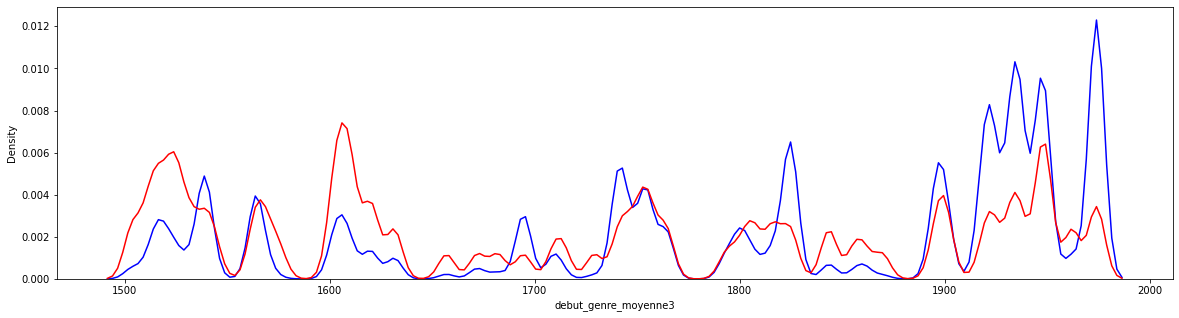

In [213]:
date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', color = 'blue', data = df_genre[BOOL_genre])
sns.kdeplot('debut_genre_moyenne3', bw=0.025, color = 'red', data = df_genre[BOOL_genre])

On recalcule les métriques des subgraph-année avec les poids actualisés. 

In [214]:
from tqdm import tqdm_notebook

# Year subsets and building metrics
df_auteurs = df
measure_list = {}
for année in tqdm_notebook(reversed(range(1000, 2025, 5))) :
  selected_nodes = [node for node, value in GraphAuthorLink.nodes(data=True) if (value['date_mort'] >= année) & (value['date_naissance'] <= année)] 
  subgraph = GraphAuthorLink.subgraph(selected_nodes)
  # if len(selected_nodes) > 10 :
  if len(selected_nodes) > 1 :
    try :
      volume_annuel = nx.get_node_attributes(subgraph, 'taille_html_article')
      subgraph_undirected = subgraph.to_undirected()
      subgraph_undirected_connected_components = sorted(nx.connected_components(subgraph_undirected), key=len, reverse=True)
      subgraph_undirected_giant = subgraph_undirected.subgraph(subgraph_undirected_connected_components[0])
      total_articles_len = 0
      community_giant = community_louvain.best_partition(subgraph_undirected_giant, randomize = False)
      for key in subgraph.nodes() :
        total_articles_len += np.log(nx.get_node_attributes(subgraph, 'taille_html_article')[key])
      measure_list[année] = {'average_clustering' : nx.average_clustering(subgraph),
                             'average_clustering_weight' : nx.average_clustering(subgraph, weight = 'weight'),
                             'average_clustering_weight2' : nx.average_clustering(subgraph, weight = 'weight2'),
                             'total_articles_len' : total_articles_len,
                             'modularity' : community_louvain.modularity(community_giant, subgraph_undirected_giant, weight = None),
                             'modularity_weight' : community_louvain.modularity(community_giant, subgraph_undirected_giant, weight = 'weight'),
                             'modularity_weight2' : community_louvain.modularity(community_giant, subgraph_undirected_giant, weight = 'weight2')}
    except : 
      pass

annee_data = pd.DataFrame(measure_list).T
annee_data['annee'] = annee_data.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

Et on visualise avec la variable d'étude pour une approche visuelle des corrélations.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Year')

Text(0, 0.5, 'density nb new graph')

Text(0, 0.5, 'average_clustering')

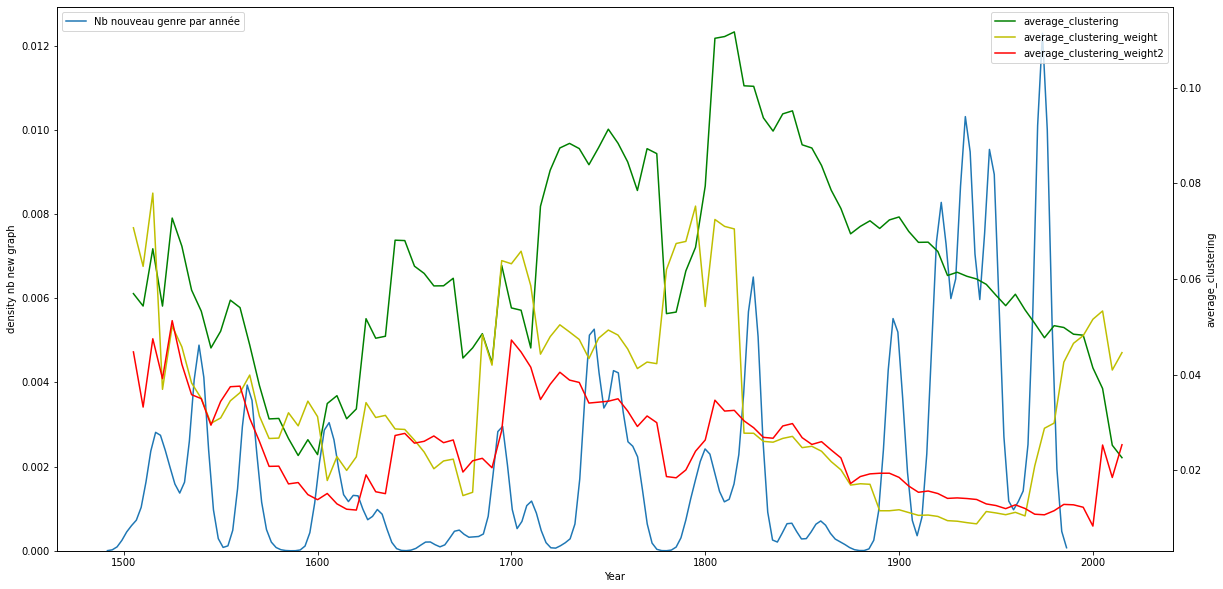

In [215]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Year')
ax1.set_ylabel('density nb new graph')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['average_clustering'][BOOL_data]*0.25, label = 'average_clustering', color = 'g')
plt.plot(annee_data['annee'][BOOL_data], annee_data['average_clustering_weight'][BOOL_data], label = 'average_clustering_weight', color = 'y')
plt.plot(annee_data['annee'][BOOL_data], annee_data['average_clustering_weight2'][BOOL_data], label = 'average_clustering_weight2', color = 'r')

plt.legend()
ax2.set_ylabel('average_clustering')

plt.show()



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Year')

Text(0, 0.5, 'density nb new graph')

Text(0, 0.5, 'modularity')

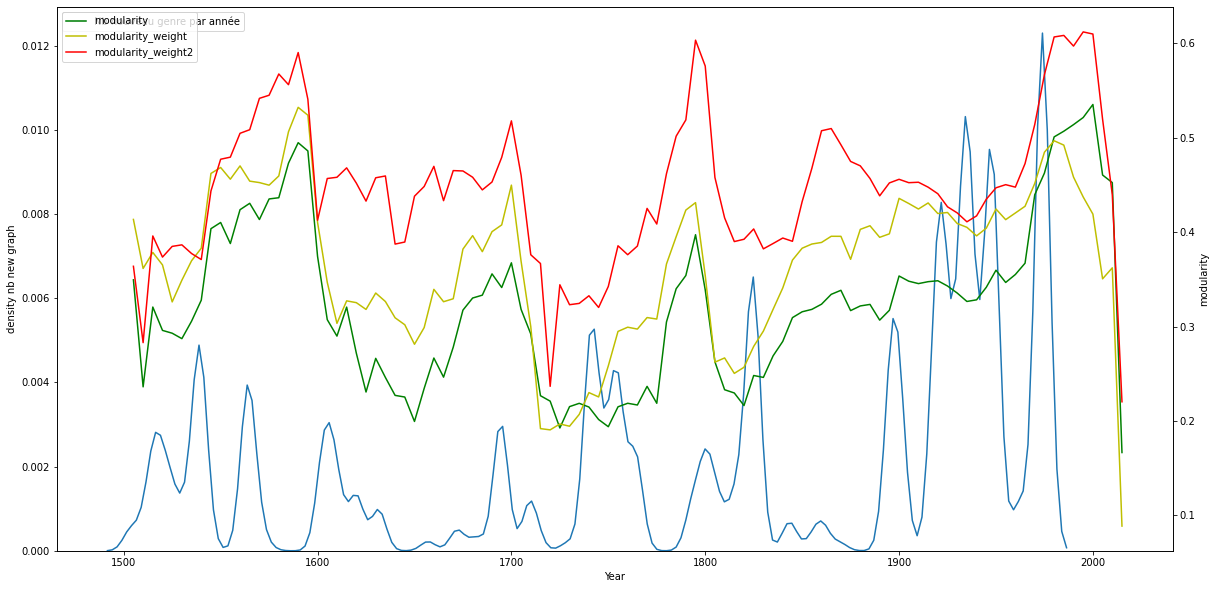

In [216]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Year')
ax1.set_ylabel('density nb new graph')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['modularity'][BOOL_data], label = 'modularity', color = 'g')
plt.plot(annee_data['annee'][BOOL_data], annee_data['modularity_weight'][BOOL_data], label = 'modularity_weight', color = 'y')
plt.plot(annee_data['annee'][BOOL_data], annee_data['modularity_weight2'][BOOL_data], label = 'modularity_weight2', color = 'r')

plt.legend()
ax2.set_ylabel('modularity')

plt.show()



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Year')

Text(0, 0.5, 'density nb new graph')

Text(0, 0.5, 'total_articles_len')

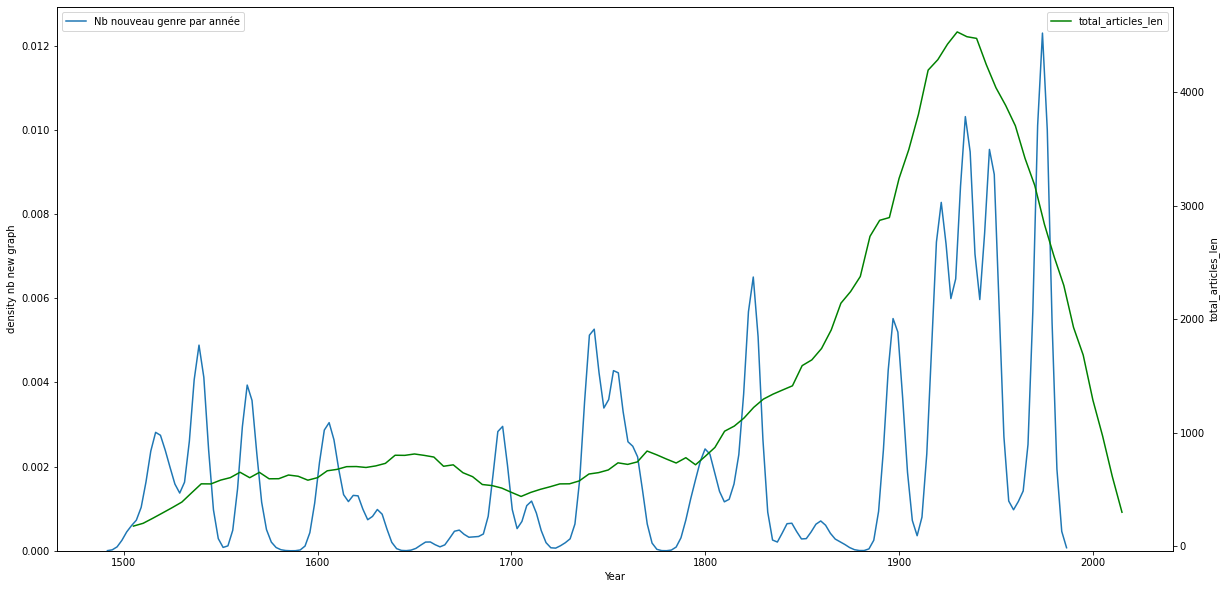

In [218]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Year')
ax1.set_ylabel('density nb new graph')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['total_articles_len'][BOOL_data], label = 'total_articles_len', color = 'g')

plt.legend()
ax2.set_ylabel('total_articles_len')

plt.show()



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


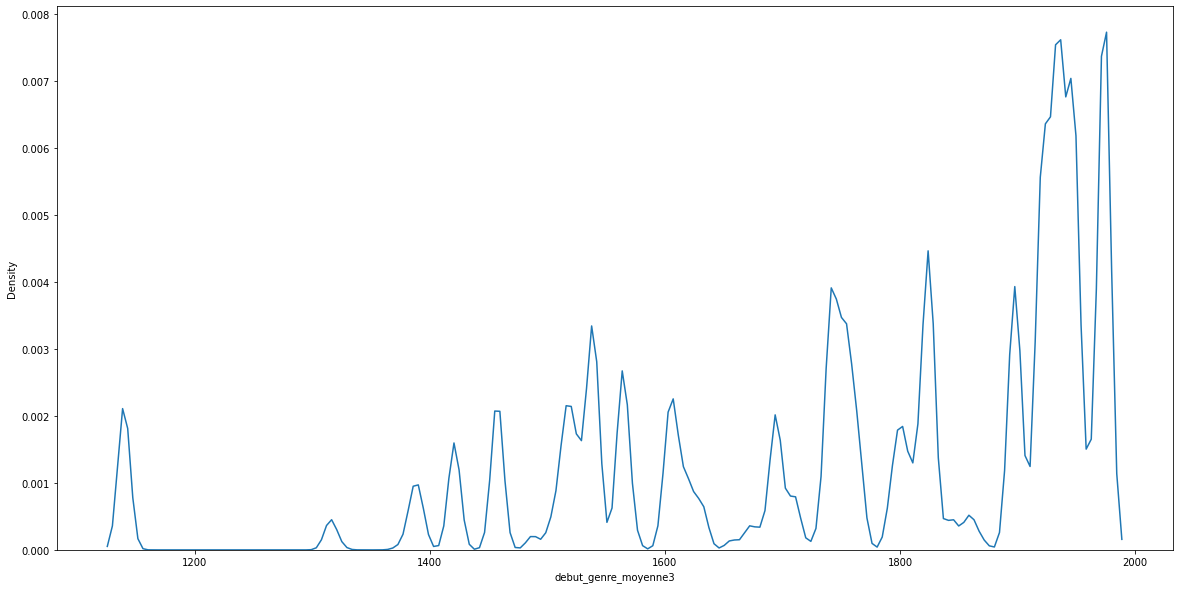

In [338]:
date_debut = 1100 
date_fin = 2100 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)

plot = sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])

annee_mean_liste = list(plot.get_lines()[0].get_data()[1])
annees = list(plot.get_lines()[0].get_data()[0])
annees = [int(annee) for annee in annees]
annee_mean_df = pd.DataFrame({'annee' : annees, 'annee_mean' : annee_mean_liste})
annee_mean_df = pd.merge(pd.DataFrame({'annee' : range(date_debut, date_fin)}), annee_mean_df, on = 'annee', how = 'outer')
annee_mean_df['annee_mean'][-1:] = 0
annee_mean_df['annee_mean_interpolated' ] = annee_mean_df.annee_mean.interpolate(method = 'polynomial', order = 2, limit_direction = 'both')

regression_data = pd.merge(annee_data, annee_mean_df, on = 'annee', how = 'inner')

In [339]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import statsmodels.formula.api as smf

def regression(periode, var_dependante, vars_explicatives, vars_controle, data_reg, lag_explicatives = 0, annee_correction = 0) :

  regression_subset = data_reg

  regression_subset[var_dependante] = regression_subset[var_dependante] + annee_correction
  regression_subset[vars_controle] = regression_subset[vars_controle] + annee_correction

  date_debut = periode[0] 
  date_fin = periode[1] 
  BOOL_regression = (regression_subset['annee'] > date_debut) & (regression_subset['annee'] < date_fin)
  regression_subset = regression_subset[BOOL_regression]

  for var in vars_explicatives :
    regression_subset[var] = regression_subset[var].shift(int(lag_explicatives/5))

  expression = var_dependante + ' ~ ' + ' + '.join(vars_explicatives) + ' + ' + ' + '.join(vars_controle)
  model = smf.ols(expression, data = regression_subset).fit()
  summary = model.summary()
  params = '\n'.join(['periode' + ' :  ' + str(periode), 
                     'var_dependante' + ' :  ' + str(var_dependante), 
                     'vars_explicatives' + ' :  ' + str(vars_explicatives), 
                     'vars_controle' + ' :  ' + str(vars_controle), 
                     'lag_explicatives' + ' :  ' + str(lag_explicatives),
                     'annee_correction' + ' : ' + str(annee_correction)])
  
  return(summary, params)


In [342]:
reg, params = regression(periode = [1500, 1990],
                         var_dependante = 'annee_mean_interpolated',
                         vars_explicatives = ['modularity_weight2', 'average_clustering_weight2'],
                         vars_controle = ['total_articles_len', 'annee'],
                         lag_explicatives = 50,
                         annee_correction = 30, 
                         data_reg = regression_data)
print(params)
print(reg)
print('\n\n\n888888888888888888888888888888888888888888888888888888888888888888888888888888888888\n\n\n')


periode :  [1500, 1990]
var_dependante :  annee_mean_interpolated
vars_explicatives :  ['modularity_weight2', 'average_clustering_weight2']
vars_controle :  ['total_articles_len', 'annee']
lag_explicatives :  50
annee_correction : 30
                               OLS Regression Results                              
Dep. Variable:     annee_mean_interpolated   R-squared:                       0.202
Model:                                 OLS   Adj. R-squared:                  0.163
Method:                      Least Squares   F-statistic:                     5.182
Date:                     Thu, 28 Apr 2022   Prob (F-statistic):           0.000900
Time:                             10:57:10   Log-Likelihood:                 481.89
No. Observations:                       87   AIC:                            -953.8
Df Residuals:                           82   BIC:                            -941.4
Df Model:                                4                                         
Covariance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
